<a href="https://colab.research.google.com/github/shayaan-ahm3d/AVAI/blob/main/Lab7_intro_to_INR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: Introduction to Implicit Neural Representations (INRs)
Welcome to week 7 of COMSM0159 Advanced Visual AI!

The goal of this labsheet is to provide an introduction to Implicit Neural Representations (INRs). By the end of this lab, you should be able to do the following:
1. Understand how INRs work and build a simple INR for image representation.
2. Experiment with your INR model for image deblurring.
3. Analyze the memory efficiency of INRs.


## Section 1: INR for Image Representation
Implicit Neural Representations (INRs) formulates a neural network (e.g., MLP) that can take the spatial co-ordinates of a signal and output the corresponding signal value. For 2D images, an INR learns an implicit function that takes pixel coordinates as input and returns the corresponding (R, G, B) values for that location. The memory required for such a representation scales with the complexity of the signal.

In this lab we will experiment with SIREN (Implicit Neural Activations with Periodic Activation Functions) as our main method. SIREN replaces the ReLU function in the MLP with a sine function as the activation function in the neural network layers, allowing it to model signals with fine details.

In [17]:
from dataset import Div2kDataset, Mode

import numpy as np
import torch
import torch.nn as nn
from scipy.ndimage import laplace, sobel
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageFilter
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import matplotlib.pyplot as plt

### Step 1 Initialize SIREN Layers
The sine layer is the basic building block of SIREN. SIREN is essentially a MLP (multi-layer perceptron) with sine activation. Note that SIREN is highly dependent on weights initialization to preserve the distribution of activations through the network. The authors propose the following initializations (check section 3.2 in the paper if you are interested):

* Weight is uniformly distributed such that
$$
w_i \sim U\left(-\frac{c}{\sqrt{n}}, \frac{c}{\sqrt{n}}\right)
$$
where c = 6.
    
* Initialize the first layer of the sine network with weights so that the sine function can be:
$$
\sin(\omega_0 \cdot W\mathbf{x} + b)
$$
where `omega_0` = 30.
  
To simplify, the key point here is that these initializations ensure the input to each sine activation is normally distributed with a standard deviation of 1, while the output of a SIREN is always arcsine distributed within the range of [-1, 1].

**Task 1:** Now complete the forward function below. Follow the equation provided below to complete the forward function. Try using [torch.sin()](https://pytorch.org/docs/stable/generated/torch.sin.html) as your sine activation function.
$$
\sin(\omega_0 \cdot W\mathbf{x} + b)
$$



In [18]:
class SineLayer(nn.Module):
    """ Linear layer followed by the sine activation

    If `is_first == True`, then it represents the first layer of the network.
    In this case, omega_0 is a frequency factor, which simply multiplies the activations before the nonlinearity.
    Note that it influences the initialization scheme.

    If `is_first == False`, then the weights will be divided by omega_0 so as to keep the magnitude of activations constant,
    but boost gradients to the weight matrix.
    """

    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30.):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        # Initialize a linear layer with specified input and output features
        # 'bias' indicates whether to include a bias term
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    # initialize weights uniformly
    def init_weights(self):
        # diasble gradient calculation in initialization
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        # Task 1 TODO
        # 1. pass input through linear layer (self.linear layer performs the linear transformation on the input)
        x = self.linear(input)

        # 2. scale the output of the linear transformation by the frequency factor
        x = x * self.omega_0

        # 3. apply sine activation
        x = torch.sin(x)

        return x

Now let's build up SIREN layers.


In [19]:
class Siren(nn.Module):
    """ SIREN architecture """

    def __init__(self, in_features, out_features, hidden_features=256, hidden_layers=3, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        # add the first layer
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        # append hidden layers
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))


        if outermost_linear:
            # add a final Linear layer
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad(): # weights intialization
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            # otherwise, add a SineLayer
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net) # sequential wrapper of SineLayer and Linear

    def forward(self, coords):
        # coords represents the 2D pixel coordinates
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

### Step 2 Data Preparation

Let's generate a grid of coordinates over a 2D space and reshape the output into a flattened format.

In [20]:
def get_mgrid(sidelen1,sidelen2, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''

    if sidelen1 >= sidelen2:
      # use sidelen1 steps to generate the grid
      tensors = tuple(dim * [torch.linspace(-1, 1, steps = sidelen1)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim = -1)
      # crop it along one axis to fit sidelen2
      minor = int((sidelen1 - sidelen2)/2)
      mgrid = mgrid[:,minor:sidelen2 + minor]

    if sidelen1 < sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps = sidelen2)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim = -1)

      minor = int((sidelen2 - sidelen1)/2)
      mgrid = mgrid[minor:sidelen1 + minor,:]

    # flatten the gird
    mgrid = mgrid.reshape(-1, dim)

    return mgrid

Make sure we convert the input to tensor and do normalization using transformations to the range [-1, 1], which corresponds to a mean of 0.5 and a standard deviation of 0.5.

In [21]:
def image_to_tensor(img):
    transform = Compose([
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

We are going to load and train an image from the [CelebFaces Attributes Dataset (CelebA)](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset. CelebA is a large-scale face attributes dataset with more than 200K celebrity images.

To save you some time, you can directly download images from the celebDataset from the cloud below (a total of three celebrity face images are prepared for this lab: face1.jpg, face2.jpg, and face3.jpg for selection), or feel free to use any image you like.

In [22]:
# Let the first image be our input
#!git clone https://github.com/shayaan-ahm3d/AVAI-week2.git
#!mv AVAI-week2/* ./
low = Image.open("0001x8.png")
high = Image.open("0001.png")
# Get width and height
width, height = low.size
print(f"Width: {width}, Height: {height}")
width, height = high.size
print(f"Width: {width}, Height: {height}")

Width: 255, Height: 175
Width: 2040, Height: 1404


**Task 2:** Visualize the input image

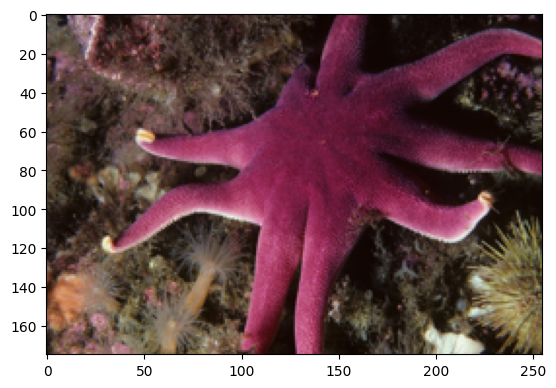

In [ ]:
tensor = image_to_tensor(low)
display_tensor = tensor * 0.5 + 0.5  # map back to [0,1]
plt.imshow(display_tensor.permute(1, 2, 0))
plt.pause(0.1)

In [30]:
%pip install lpips
from dip_super_resolution import generate_patch_coords
patch_coords = list(generate_patch_coords(height=high.size[1], width=high.size[0], patch_size=256, overlap=0))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.2 MB/s eta 0:00:00
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 203MB/s] 


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


### Step 3 Training and Fitting an Image

In [ ]:
# set the device to 'cuda' if available, otherwise 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create an ImageData instance
#input_image = 
#dataloader = DataLoader(input_image, batch_size=1, pin_memory=True, num_workers=0)

# initialize a SIREN model
img_siren = Siren(in_features=2, out_features=3, hidden_features=256,
                  hidden_layers=3, outermost_linear=True).to(device)

/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
# define differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

**Task 3:**

* Compute the gradient and the Laplacian of the output.

* Visualize the model output, gradient output and laplacian output.

*  What patterns do you notice in the gradient output compared to the model output? How do the edges detected by the Laplacian correlate with features in the model output?

Answer: able to explain where the model is sensitive to changes in input, and describe Laplacian (second derivative) can highlight areas of rapid intensity change - edges.

In [28]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input = torch.tensor(np.array(low, dtype=float)).to(device).permute(2, 0, 1)
ground_truth =  torch.tensor(np.array(high, dtype=float)).to(device).permute(2, 0, 1)

print(model_input.shape, ground_truth.shape)

for step in range(total_steps):
    coords = get_mgrid(high.height, high.width).to(device).float()
    target = torch.tensor(np.array(high, dtype=np.float32)).permute(2, 0, 1).reshape(3, -1).permute(1, 0).to(device)
    model_output, coords = img_siren(coords)
    loss = ((model_output - target)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        # Task 3
        # Compute the gradient and the Laplacian of the output.
        # Visualize the model output, gradient output and laplacian output.
        # What patterns do you notice in the gradient output compared to the model output? How do the edges detected by the Laplacian correlate with features in the model output?
        lap = laplace(model_output, coords)
        grad = gradient(model_output, coords)

        (channels, height, width) = ground_truth.shape

        output_img = model_output.detach().cpu().view(height, width, channels).numpy()
        grad_magnitude_img = grad.norm(dim=-1).detach().cpu().view(height, width).numpy()
        laplacian_img = lap.detach().cpu().view(height, width).numpy()

        plots = [output_img, grad_magnitude_img, laplacian_img]
        titles = ['Model Output', 'Gradient Magnitude', 'Laplacian']
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i, (plot, title) in enumerate(zip(plots, titles)):
            axes[i].imshow(plot.squeeze(), cmap='gray')
            axes[i].set_title(title)
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

torch.Size([3, 175, 255]) torch.Size([3, 1404, 2040])


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.73 GiB. GPU 0 has a total capacity of 14.74 GiB of which 798.12 MiB is free. Process 4197 has 13.96 GiB memory in use. Of the allocated memory 13.81 GiB is allocated by PyTorch, and 21.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Section 2: INR for Deblurring

Implicit neural representations can also be used for 2D image processing tasks like denoising, deblurring, inpainting, and super-resolution.

In this section, we will explore INR for non-blind deblurring.

### Step 1 Define Blurring Kernel

In [ ]:
# Creating and Applying Blurring Kernels
# util: https://github.com/GaryMataev/DeepRED
def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function (Creates a Gaussian blurring kernel)
    """
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1, -size // 2 + 1:size // 2 + 1]
    g = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    return g / g.sum()

def get_fft_h(im, blur_type):
    """Computes the Fourier transform of a blurring kernel
    """
    assert blur_type in ['uniform_blur', 'gauss_blur'], "blur_type can be or 'uniform' or 'gauss'"
    ch, h, w = im.shape
    fft_h    =  np.zeros((h,w),)
    if blur_type=='uniform_blur':
        t        =  4 # 9//2
        fft_h[h//2-t:h//2+1+t, w//2-t:w//2+1+t]  = 1/81
        fft_h    = np.fft.fft2(np.fft.fftshift(fft_h))
    else: # gauss_blur
        psf = fspecial_gauss(25, 1.6)
        t = 12 # 25 // 2
        fft_h[h//2-t:h//2+1+t, w//2-t:w//2+1+t]  = psf
        fft_h    =  np.fft.fft2(np.fft.fftshift(fft_h))
    return fft_h

def blur(im, blur_type):
    """Apply blur kernel to the input image
    """
    fft_h = get_fft_h(im, blur_type)
    imout = np.zeros_like(im)
    for i in range(im.shape[0]):
        im_f    =  np.fft.fft2(im[i, :, :])
        z_f     =  fft_h*im_f # .* of matlab
        z       =  np.real(np.fft.ifft2(z_f))
        imout[i, :, :] = z
    return imout


# - the inverse function H -
def get_h(n_ch, blur_type, use_fourier, dtype):
    assert blur_type in ['uniform_blur', 'gauss_blur'], "blur_type can be or 'uniform' or 'gauss'"
    if not use_fourier:
        return Downsampler(n_ch, 1, blur_type, preserve_size=True).type(dtype)
    return lambda im: torch_blur(im, blur_type, dtype)


def torch_blur(im, blur_type, dtype):
  # blur an image tensor
    fft_h = get_fft_h(torch_to_np(im), blur_type)
    fft_h_torch = torch.unsqueeze(torch.from_numpy(np.real(fft_h)).type(dtype), 2)
    fft_h_torch = torch.cat([fft_h_torch, fft_h_torch], 2)
    z = []
    for i in range(im.shape[1]):
        im_torch = torch.unsqueeze(im[0, i, :, :], 2)
        im_torch = torch.cat([im_torch, im_torch], 2)
        im_f    =  torch.fft(im_torch, 2)
        z_f     =  torch.mul(torch.unsqueeze(fft_h_torch, 0), torch.unsqueeze(im_f, 0)) # .* of matlab
        z.append(torch.ifft(z_f, 2))
    z = torch.cat(z, 0)
    return torch.unsqueeze(z[:, :, :, 0], 0)

In [ ]:
def add_gaussian_noise(img, sigma):
    # add noise on blur image
    if sigma > 0:
        noise = np.random.normal(scale=sigma , size=img.shape).astype(np.float32)

        noisy_img = (img + noise).astype(np.float32)
    else:
        noisy_img = img.astype(np.float32)
    #noisy_img=np.clip(noisy_img, 0.0, 1.0)
    return noisy_img

### Step 2 Data Preparation

In [ ]:
def get_blur_image(img):

    img = np.array(img).astype(np.float32)/255 # normalize to [0, 1]
    img = img.transpose(2, 0, 1)

    # blur
    img = blur(img,blur_type="gauss_blur")
    sigma = 2**.5

    # add noise
    img = add_gaussian_noise(img, sigma/255)
    img = np.clip(img,0,1) #clip to [0,1]

    # scale to [-1, 1]
    img = (img - 0.5)*2

    plt.imshow(np.squeeze((img.transpose(1,2,0)+1)/2))
    plt.pause(0.1)

    blur_tensor = torch.tensor(img)
    return blur_tensor

In [ ]:
# Blur Dataset
class ImageBlur(Dataset):
    def __init__(self,img):
        super().__init__()

        img = get_blur_image(img)

        self.pixels = img.permute(1, 2, 0).view(-1, 3)

        self.coords = get_mgrid(img.shape[1],img.shape[2],dim=2)
    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

In [ ]:
deblur_celeb = ImageBlur(low)
deblur_dataloader = DataLoader(deblur_celeb, batch_size=1, pin_memory=True, num_workers=0)

# create a siren model ready for deblurring
deblur_siren = Siren(in_features=2, out_features=3, hidden_features=256,
                  hidden_layers=6, outermost_linear=True)
deblur_siren.to(device)

In [ ]:
class Downsampler(nn.Module):
    """
        Resampling filters
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    """

    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None,
                 preserve_size=False, pad_type='reflection', transpose_conv=False):
        super(Downsampler, self).__init__()

        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1 / 2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1. / np.sqrt(2)
            kernel_type_ = 'gauss'

        elif kernel_type == 'uniform_blur':
            kernel_width = 9
            kernel_type_ = 'uniform'
            pad_type = 'circular'

        elif kernel_type == 'gauss_blur':
            kernel_width = 25
            sigma = 1.6
            kernel_type_ = 'gauss'
            pad_type = 'circular'

        elif kernel_type in {'lanczos', 'gauss', 'box'}:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'

        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)
        if transpose_conv:
            if self.kernel.shape[0] % 2 == 1:
                pad = int((self.kernel.shape[0] - 1) // 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) // 2.)
            downsampler = nn.ConvTranspose2d(n_planes, n_planes, kernel_size=self.kernel.shape,
                                             stride=factor, padding=pad)
        else:
            downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch

        self.downsampler_ = downsampler

        if preserve_size:
            if pad_type=='circular':
                self.padding = lambda torch_in: pad_circular(torch_in, kernel_width // 2)
            elif pad_type=='reflection':
                if self.kernel.shape[0] % 2 == 1:
                    pad = int((self.kernel.shape[0] - 1) // 2.)
                else:
                    pad = int((self.kernel.shape[0] - factor) // 2.)
                self.padding = nn.ReplicationPad2d(pad)
            else:
                assert False, "pad_type have only circular or reflection options"
        self.preserve_size = preserve_size

    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x = input
        self.x = x
        return self.downsampler_(x)


def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box', 'uniform', 'blur']

    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box':
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])

    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1. / (kernel_width * kernel_width)

    elif kernel_type == 'gauss':
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'
        return fspecial_gauss(kernel_width, sigma)

    elif kernel_type == 'uniform':
        kernel = np.ones([kernel_width, kernel_width])

    elif kernel_type == 'lanczos':
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):#print metrics

                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor
                    dj = abs(j + 0.5 - center) / factor
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor

                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)

                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)
                kernel[i - 1][j - 1] = val
    else:
        assert False, 'wrong method name'
    kernel /= kernel.sum()
    return kernel


def pad_circular(x, pad):
    """
    :param x: pytorch tensor of shape: [batch, ch, h, w]
    :param pad: uint
    :return:
    """
    x = torch.cat([x, x[:, :, 0:pad]], dim=2)
    x = torch.cat([x, x[:, :, :, 0:pad]], dim=3)
    x = torch.cat([x[:, :, -2*pad:-pad], x], dim=2)
    x = torch.cat([x[:, :, :, -2*pad:-pad], x], dim=3)
    return x

In [ ]:
# define blur_type
blur_type = "gauss_blur"
downsampler = Downsampler(3, 1, blur_type, preserve_size=True).to(device)

### Step 3 Training and Deblurring

**Task 4:** Visualize output

Step 0, Total loss 0.356748


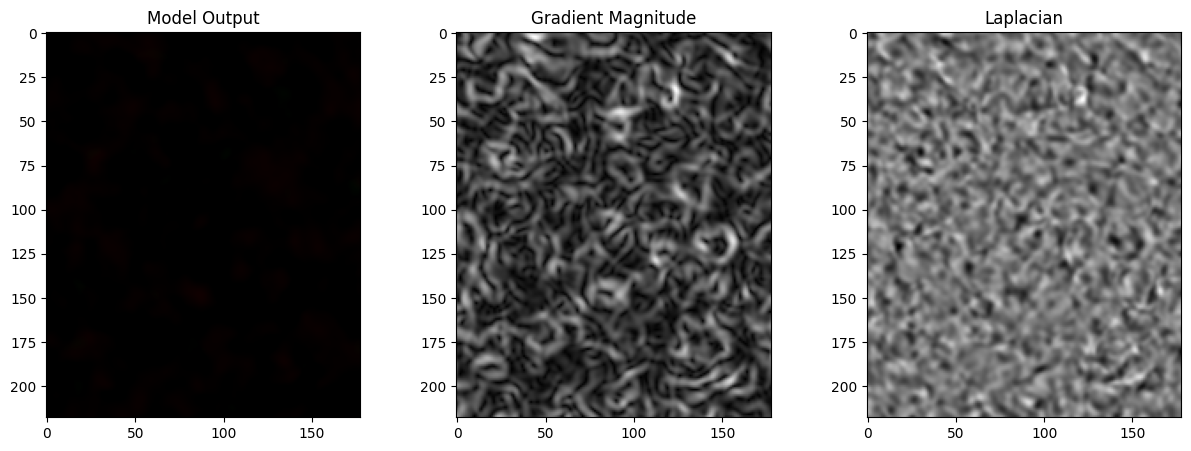

Step 500, Total loss 0.294088


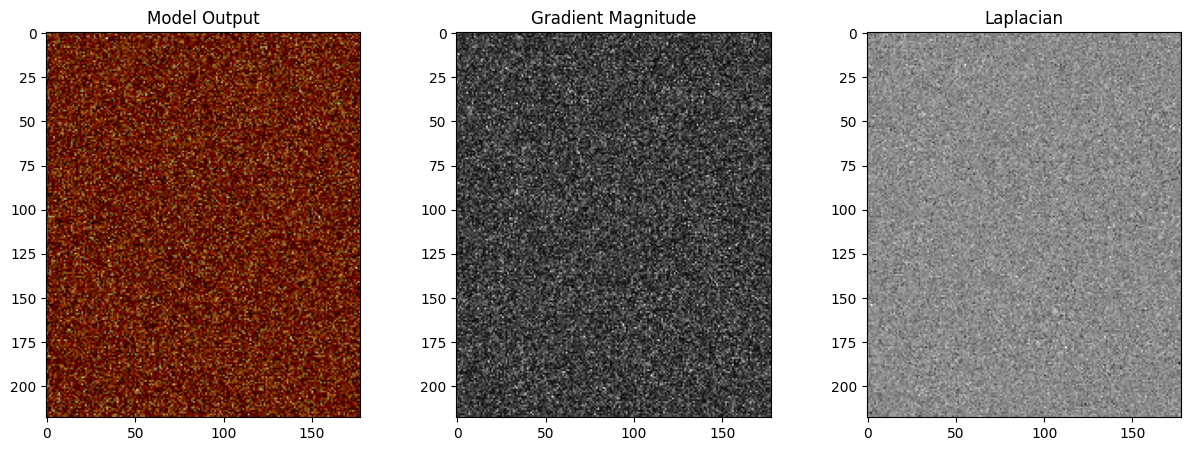

Step 1000, Total loss 0.293896


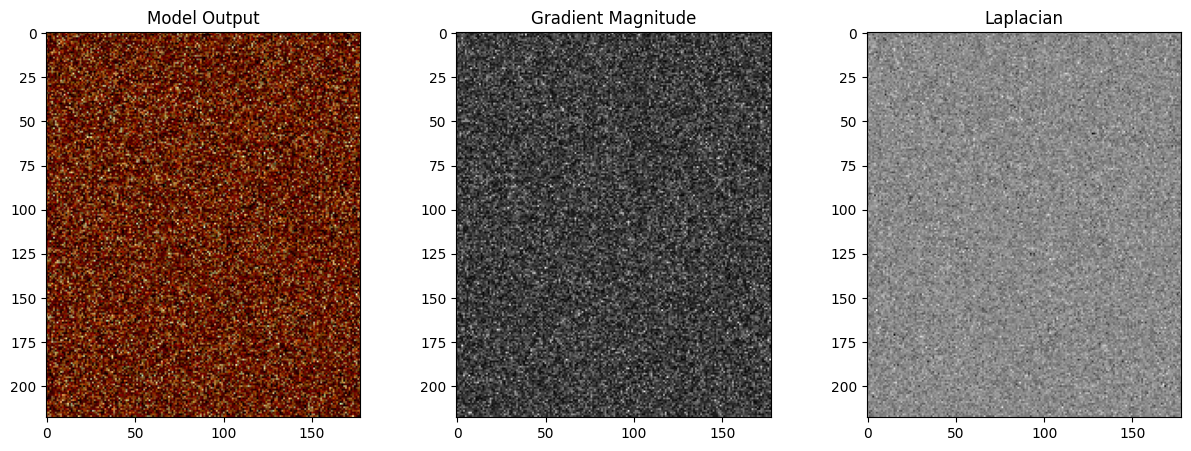

Step 1500, Total loss 0.293125


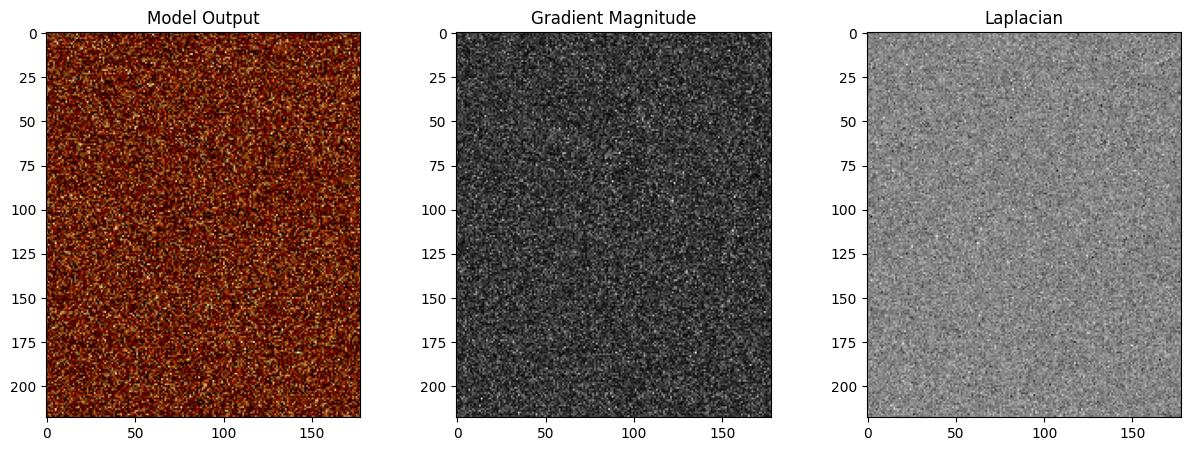

Step 2000, Total loss 0.293252


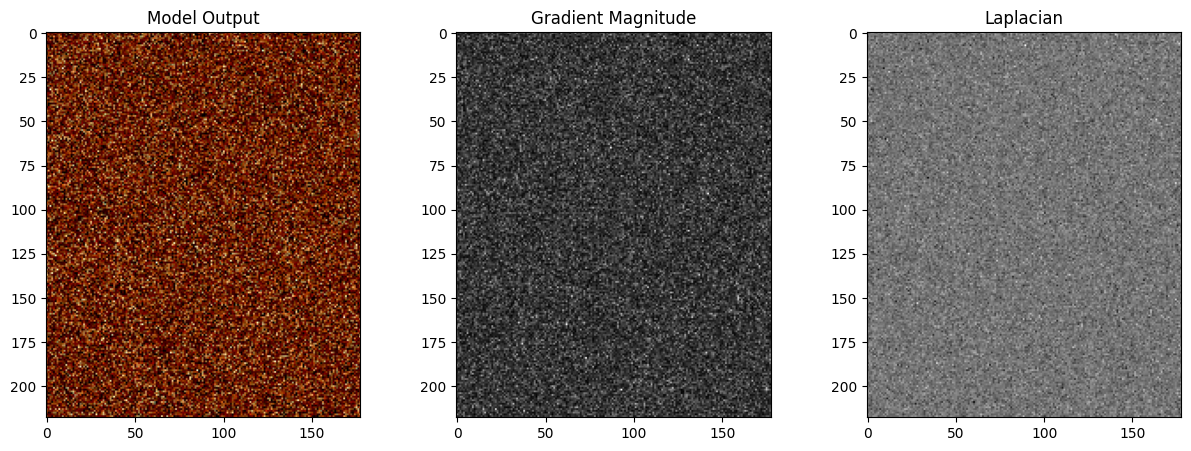

Step 2500, Total loss 0.295155


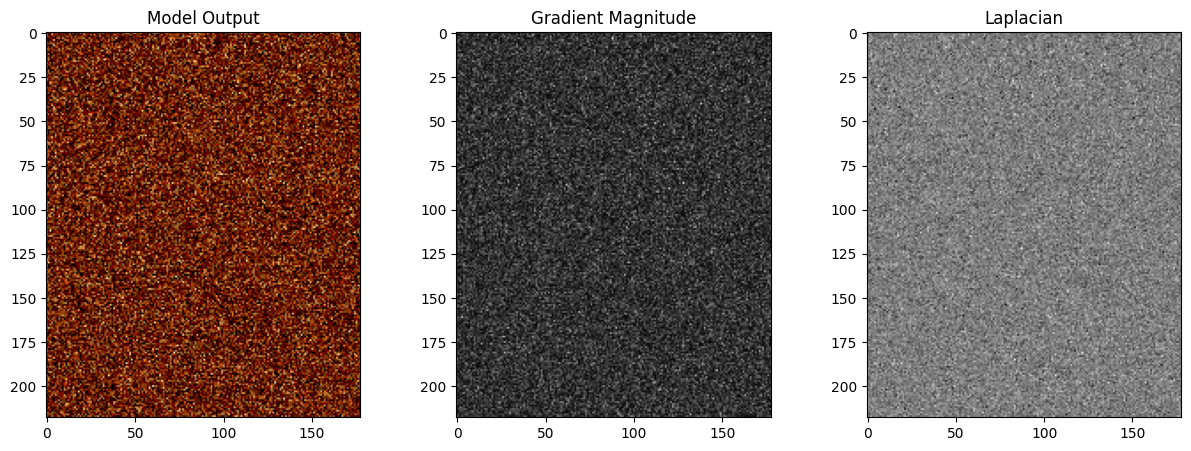

Step 3000, Total loss 0.294861


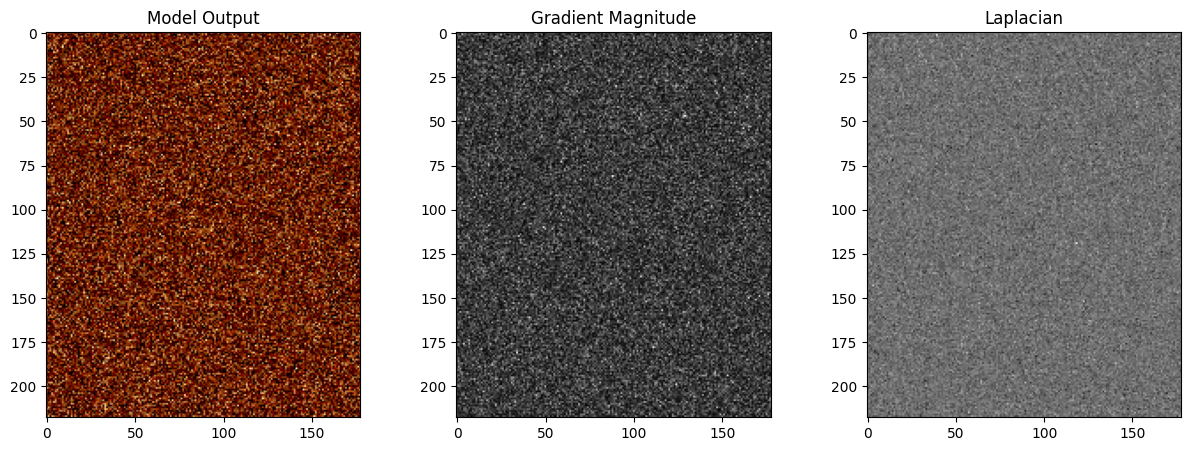

Step 3500, Total loss 0.295480


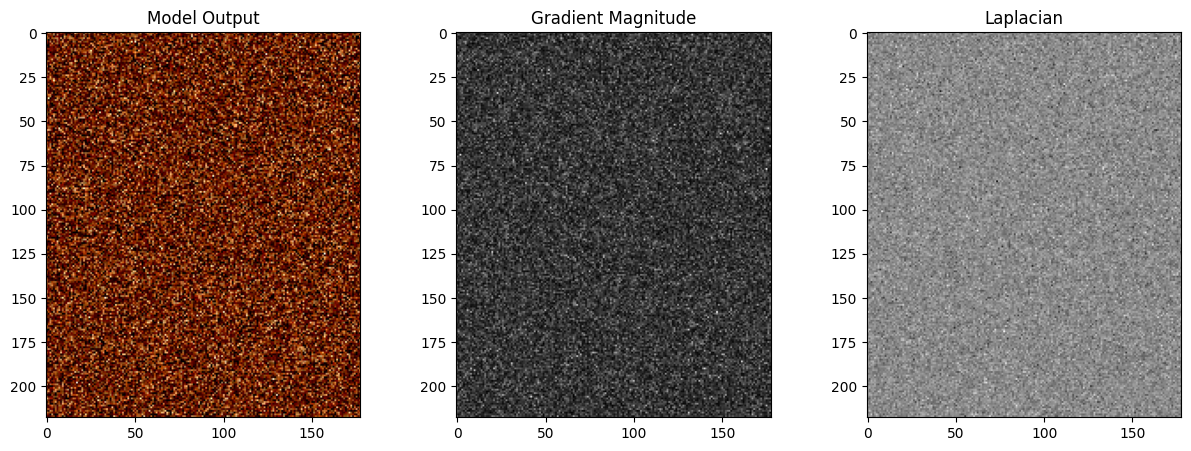

Step 4000, Total loss 0.295316


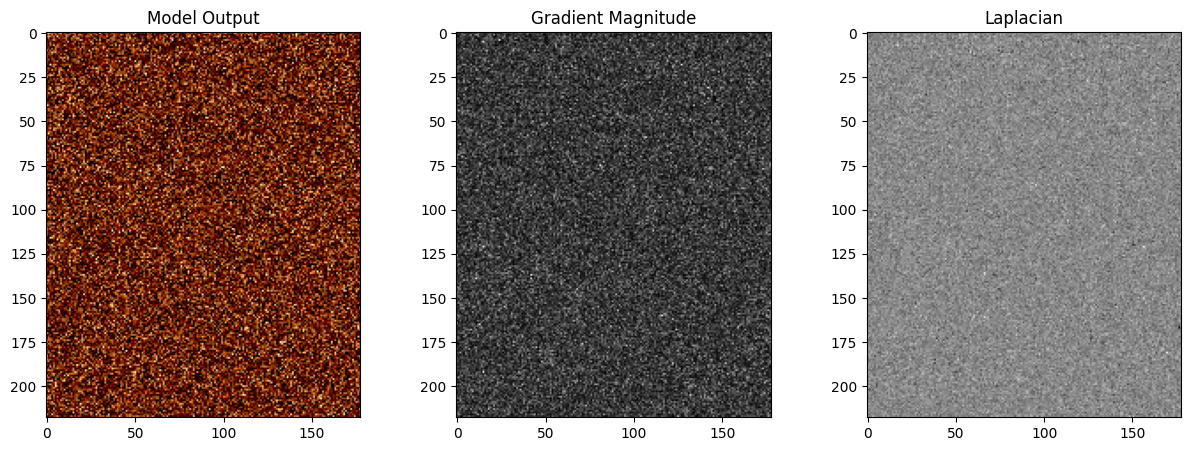

Step 4500, Total loss 0.294535


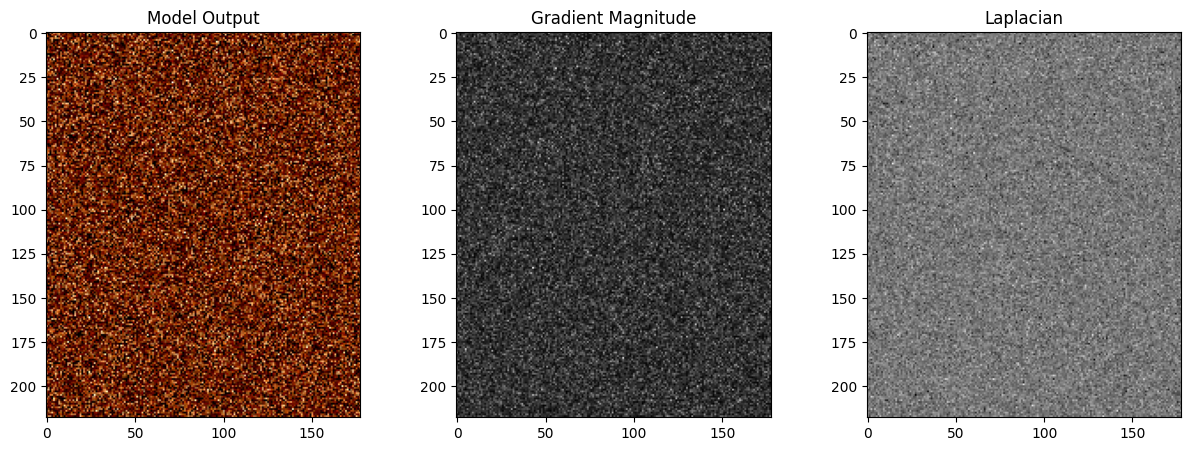

In [ ]:
total_steps = 5000
steps_til_summary = 500

optim = torch.optim.Adam(lr=1e-2, params=img_siren.parameters())

model_input, ground_truth = next(iter(deblur_dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)

    model_outputnew = (downsampler(model_output.view(1,218,178,3).permute(0,3,1,2))).permute(0,2,3,1).view(1,-1,3)

    loss = ((model_outputnew - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        # Task 4 TODO
        lap = laplace(model_output, coords)
        grad = gradient(model_output, coords)

        (channels, height, width) = tensor.shape

        output_img = model_output.detach().cpu().view(height, width, channels).numpy()
        grad_magnitude_img = grad.norm(dim=-1).detach().cpu().view(height, width).numpy()
        laplacian_img = lap.detach().cpu().view(height, width).numpy()

        plots = [output_img, grad_magnitude_img, laplacian_img]
        titles = ['Model Output', 'Gradient Magnitude', 'Laplacian']
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i, (plot, title) in enumerate(zip(plots, titles)):
            axes[i].imshow(plot.squeeze(), cmap='gray')
            axes[i].set_title(title)
        plt.show()


    optim.zero_grad()
    loss.backward()
    optim.step()



## Section 3 Think about Memory Efficiency

**Challenge:**
* Calculate and compare memory usage for traditional grid-based (pixel-based) representations and representations in INR.
* What advantages might this offer in terms of efficiency for storing and representing high-dimensional data? Can you think of other potential applications of implicit neural representations (INR) beyond low-level vision tasks (e.g., denoising,debluring)?